This project will be focused on applying various classification models and selecting the best based on their performance on the dataset. Models will attempt to identify genes associated with age-related diseases.
The dataset includes genes encoding sequence-based features (hydrophobicity, polarity, polarizability, secondary structure, Van der Waals volume, charge, solvent accessibility, etc.)

I prefer maintaining my projects within Windows Subsystem for Linux. For this reason, we must isolate our working environment for safety and reproducibility.
To do so, let's install a virtual environment globally.

In [ ]:
pip install virtualenv

Now we can run our virtual environment with a compatible python version (in WSL2 We have to specify the absolute path to our python installation file.):

In [ ]:
virtualenv -p /root/.pyenv/versions/3.7/bin/python3.7 age_genes_vnv

# Now let's install the required dependencies from the requirements file (created previously with pip freeze command for convenience).


In [ ]:
pip install -r https://raw.githubusercontent.com/dmy-collab/shared-projects/main/requirements.txt

##In case of any issues, we can install packages manually:

In [ ]:
pip install pandas


In [ ]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 1.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Importing libraries

In [2]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('max_seq_item', None)
pd.set_option('display.width', 1000)

# Importing the file:

In [3]:
!wget https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Find_age_related_deseases_genes/Genes_dataset.xlsx
dataset = pd.read_excel('Genes_dataset.xlsx')

--2021-07-30 21:37:52--  https://raw.githubusercontent.com/dmy-collab/shared-projects/main/Find_age_related_deseases_genes/Genes_dataset.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244514 (239K) [application/octet-stream]
Saving to: ‘Genes_dataset.xlsx’

Genes_dataset.xlsx  100%[===================>] 238.78K  --.-KB/s    in 0.03s   

2021-07-30 21:37:52 (8.78 MB/s) - ‘Genes_dataset.xlsx’ saved [244514/244514]



# Initial analysis:

In [ ]:
print(dataset.shape)
dataset['Target'].value_counts()
nulls = dataset.isnull().sum().to_frame()   # searching for missing values
for index, row in nulls.iterrows():
    print(index, row[0])

(658, 75)
Gene_Symbol 0
Uniprot_ID 0
Polar 0
Neutral 0
Hydrophobicity 0
0-2.78 0
2.95-4.0 0
4.03-8.08 0
4.9-6.2 0
8.0-9.2 0
10.4-13.0 0
0-1.08 0
0.128-0.186 0
0.219-0.409 0
Positive 0
Neutral.1 0
Negative 0
Buried 0
Exposed 0
Intermediate 0
Helix 0
Strand 0
Coil 0
(-0.20~0.16) 0
(-0.3~ -0.52) 0
(-0.98~ -2.46) 0
High (5-21%) 0
Medium (1.12-3.64%) 0
Low (0-0.83%) 0
High (1.21-2.02) 0
Medium (0.63-1.12) 0
Low (0.14-0.29) 0
High (4-30%)  0
Medium (1-3%)  0
Low (0-1%)  0
High (25-100%)  0
Medium (5-18%)  0
Low (0-4%)  0
High (0.25-11)  0
Medium (-0.25 – 0.17)  0
Low (-0.3 - -0.8)  0
High (1.18-2.07)  0
Medium (0.84-1.16)  0
Low (0.41-0.8)  0
High (0.95-1.8)  0
Medium (0.5-0.95)  0
Low (0-0.5)  0
High (?2.25)  0
Medium (1.6-2.3)  0
Low (?1.5)  0
High  (?1.4)  0
Medium (0.79-1.21)  0
Low (?0.76)  0
High (477-1197)  0
Medium (95-423)  0
Low (<95)  0
Low (75-105) 0
Medium (115-155) 0
High (165-204) 0
(-4.2 - -3.3) 0
(-3.07 – 2.26) 0
(-1.78 - -1.05) 0
>1 0
1 0
0 0
>1.1 0
1.1 0
0.1 0
High (9-65 g

# Splitting the dataset on features and labels:

In [4]:
X = dataset.iloc[:, 2:-1].values    # features
y = dataset.iloc[:, -1].values      # labels

# Data scaling:

In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_norm = sc.fit_transform(X)

# PCA:

In [6]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=2)
PCs = sklearn_pca.fit_transform(X_norm)

data_transform = pd.DataFrame(PCs, columns=['PC1', 'PC2'])
data_transform = pd.concat([data_transform, dataset.iloc[:, -1]], axis=1)



> **Visualizing distribution of instances to find whether there is linearity in data distribution:**


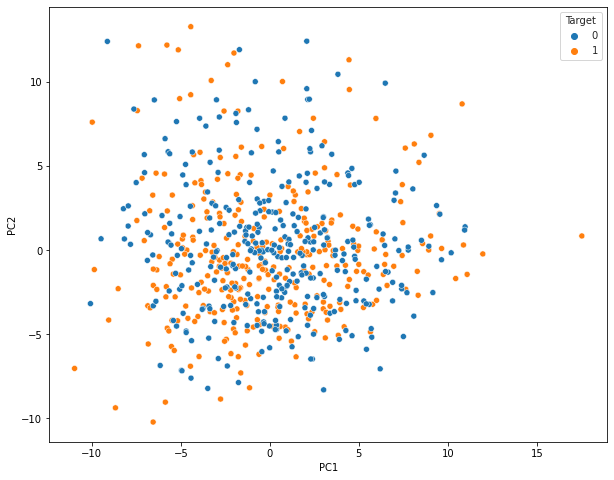

In [ ]:
fig, axes = plt.subplots(figsize=(10, 8))
sns.set_style("whitegrid")
sns.scatterplot(x='PC1', y='PC2', data=data_transform, hue='Target', cmap='grey')
plt.show()  

*We can see no linearity in data distribution; hence, linear regression will not be applicable for this dataset. Let's proceed with other methods.*



> **Splitting the dataset into the Training set and Test set:**



In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.20, random_state=101)

# Training the Logistic Regression model and evaluation:

In [8]:
from sklearn.linear_model import LogisticRegression
Logit_classifier = LogisticRegression(random_state=0)
Logit_classifier.fit(X_train, y_train)
y_pred = Logit_classifier.predict(X_test)

*Let's define a function for the evaluation output since we will utilize it for each approach.*

In [9]:
def evaluation_report(method_name):
  from sklearn.metrics import confusion_matrix, classification_report
  print(f'\n\t {method_name} model evaluation')
  print(confusion_matrix(y_test, y_pred))
  print('\n')
  print(classification_report(y_test, y_pred))

*Now let's output the evaluation report with our function.*

In [10]:
evaluation_report('Logistic regression')


	 Logistic regression model evaluation
[[33 31]
 [22 46]]


              precision    recall  f1-score   support

           0       0.60      0.52      0.55        64
           1       0.60      0.68      0.63        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.59       132
weighted avg       0.60      0.60      0.60       132



*With this method, we achieved 60% accuracy. Let's try other methods to see if we can get better results.*

# Training the k-nearest neighbors (KNN) model and evaluation:

> Choosing K Value:



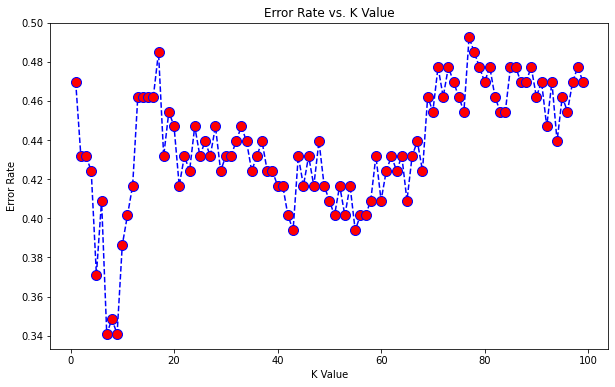

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

errors = []

for i in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    errors.append(np.mean(pred_i != y_test))

#  plotting error rate to find optimal K-value:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), errors, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.show() 

>> According to the plot, K=7 is the lowest K-value, which provides the lowest error rate; hence we will use it further.

---





> Model evaluation:



In [ ]:
KNN_classifier = KNeighborsClassifier(n_neighbors=7)
KNN_classifier.fit(X_train, y_train)
y_pred = KNN_classifier.predict(X_test)

evaluation_report('KNN')


	KNN model evaluation:
[[43 21]
 [24 44]]


              precision    recall  f1-score   support

           0       0.64      0.67      0.66        64
           1       0.68      0.65      0.66        68

    accuracy                           0.66       132
   macro avg       0.66      0.66      0.66       132
weighted avg       0.66      0.66      0.66       132



*We achieved 66% accuracy with this method. Let's try other methods to see if we can get better results.*

# Training the Random Forest model and evaluation:

In [ ]:
from sklearn.model_selection import GridSearchCV    # find optimal N of trees with grid search
from sklearn.ensemble import RandomForestClassifier
param_grid = {'n_estimators': [10, 100, 150, 200, 250, 300, 350, 400]}
RF_classifier = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=0)
RF_classifier.fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

evaluation_report('Random Forest')


	Random Forest model evaluation:
[[37 27]
 [26 42]]


              precision    recall  f1-score   support

           0       0.59      0.58      0.58        64
           1       0.61      0.62      0.61        68

    accuracy                           0.60       132
   macro avg       0.60      0.60      0.60       132
weighted avg       0.60      0.60      0.60       132



*We achieved 60% accuracy with this method. Let's try other methods to see if we can get better results.*

# Training the Support-vector machine (SVM) model and evaluation:

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
SVM_classifier = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
SVM_classifier.fit(X_train, y_train)

y_pred = SVM_classifier.predict(X_test)
evaluation_report('Random Forest')


	 SVM model and evaluation
[[37 27]
 [28 40]]


              precision    recall  f1-score   support

           0       0.57      0.58      0.57        64
           1       0.60      0.59      0.59        68

    accuracy                           0.58       132
   macro avg       0.58      0.58      0.58       132
weighted avg       0.58      0.58      0.58       132



*We achieved 58% accuracy with this method. Let's try other methods to see if we can get better results.*

# Training the artificial neural network (ANN) model and evaluation:

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(units=60, activation='relu'))
model.add(Dropout(0.5))     # minimizing overfitting with dropout layer

model.add(Dense(units=15, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model.fit(x=X_train,
          y=y_train,
          epochs=400,
          batch_size=64,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

predictions = (model.predict(X_test) > 0.5).astype("int32")
evaluation_report('ANN')

Epoch 1/400
9/9 [==============================] - 1s 30ms/step - loss: 0.9266 - accuracy: 0.5152 - val_loss: 0.7260 - val_accuracy: 0.5076
Epoch 2/400
9/9 [==============================] - 0s 5ms/step - loss: 0.8567 - accuracy: 0.4829 - val_loss: 0.7058 - val_accuracy: 0.5227
Epoch 3/400
9/9 [==============================] - 0s 5ms/step - loss: 0.8250 - accuracy: 0.5190 - val_loss: 0.6976 - val_accuracy: 0.5455
Epoch 4/400
9/9 [==============================] - 0s 6ms/step - loss: 0.7960 - accuracy: 0.5323 - val_loss: 0.6950 - val_accuracy: 0.5152
Epoch 5/400
9/9 [==============================] - 0s 7ms/step - loss: 0.8438 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5758
Epoch 6/400
9/9 [==============================] - 0s 8ms/step - loss: 0.7913 - accuracy: 0.5247 - val_loss: 0.6926 - val_accuracy: 0.5303
Epoch 7/400
9/9 [==============================] - 0s 6ms/step - loss: 0.7819 - accuracy: 0.5342 - val_loss: 0.6879 - val_accuracy: 0.5227
Epoch 8/400
9/9 [=========

*We achieved 60% accuracy with this method.*

Overall with this dataset, k-nearest neighbors (KNN) algorithm has shown the best accuracy with the lowest false-positive and false-negative prediction rates. This could be explained by the fact that it can classify non-linearly separable datasets.